In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits
from matplotlib import colors
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from ellipse import LsqEllipse

In [2]:
wray_fits = fits.open('WRAY_15-1880_SPHERE_2021-05-16_H.fits')
wray_hdu = wray_fits[0]
wray_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                    6                                                  
DATE    = '2021-05-16'         / observation date UTC (CCCC-MM-DD)              
RA      =           280.740984 / 18:42:57.84                                    
DEC     =            -35.54494 / -35:32:41.78                                   
RA_SIM  = '18 42 57.9812'      / Refined Simbad coordinates of target           
DEC_SIM = '-35 32 42.824'      / Refined Simbad coordinates of target           
EPOCH   =               2000.0 / Target Coordinate Epoch                        
SCALE   =               12.2

In [3]:
wray_data = wray_hdu.data
wray_qphi_adu = wray_data[1, :, :]
wray_qphi = wray_qphi_adu * wray_hdu.header['ZEROPT'] # converting from ADU to Jy/arcsec^2

print (np.shape(wray_data), np.shape(wray_qphi))

(6, 1024, 1024) (1024, 1024)


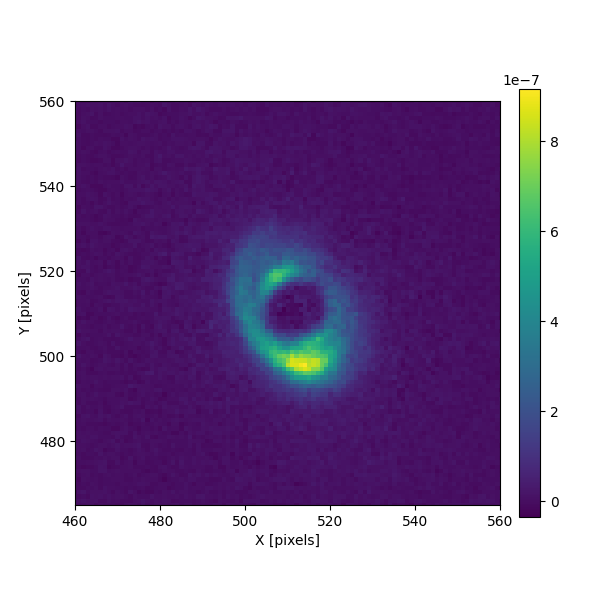

In [4]:
plt.figure(figsize=(6,6))
plt.imshow(wray_qphi, origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlim(460, 560)
plt.ylim(465, 560)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

Now we build the **mask**:

In [5]:
mask = np.ones([1024, 1024])
ylen, xlen = np.shape(mask)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

scale = wray_hdu.header['SCALE'] # number of mas/px

x_center = wray_hdu.header['STAR_X']
y_center = wray_hdu.header['STAR_Y']
radius = 92.5/scale  # width of the coronograph in pixels: the coronograph has a radius of 92.5 mas

target_distance = np.sqrt((X-x_center)**2 + (Y-y_center)**2)
aperture_selection = (target_distance < radius)

mask[aperture_selection] = 0

/tmp/ipykernel_45045/2778732225.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


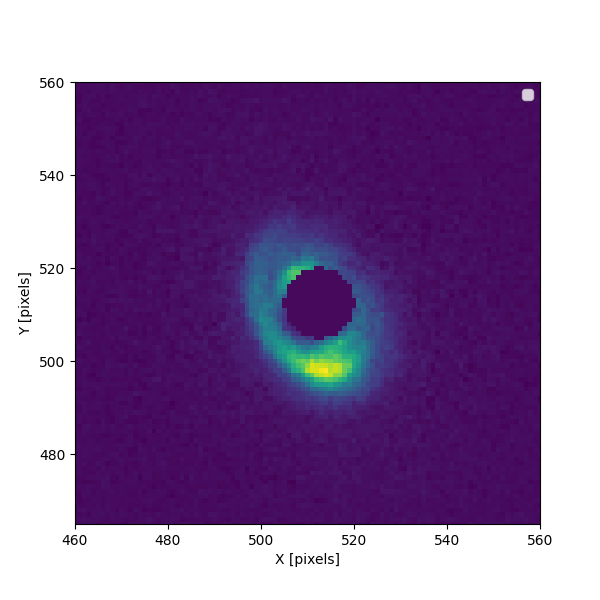

In [6]:
wray_masked = wray_qphi * mask # THIS is the masked image!!

def make_circle(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    plt.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)



plt.figure(figsize=(6,6))
plt.imshow(wray_masked)
#make_circle(x_center, y_center, radius, label='Coronograph')
plt.xlim(460, 560)
plt.ylim(465, 560)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.legend(loc='best')
plt.show()

And now we calculate the other image, multiplying each pixel for its squared distance from the center: 

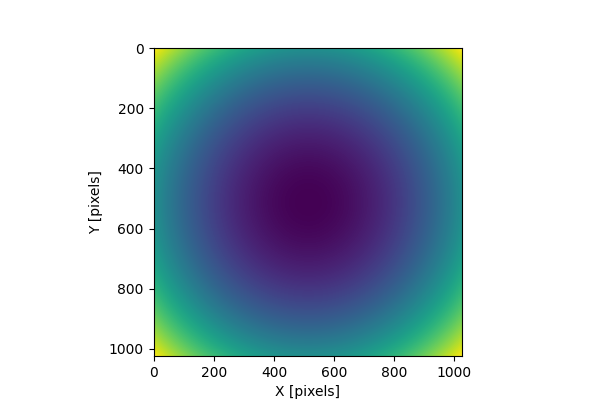

In [7]:
plt.figure(figsize=(6,4))
plt.imshow(target_distance**2)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

First, we convert the target distance from pixels to AU: each pixel corresponds to 5.94e-8 rad, while the distance is 154 pc, so 3.17648e7 AU.

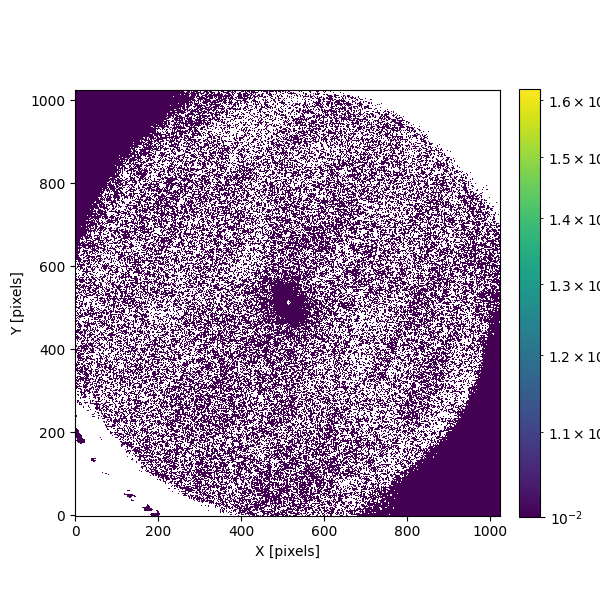

In [8]:
target_distance_AU = target_distance * 5.94e-8 * 3.17648e7
wray_mult = wray_masked * target_distance_AU**2

vmin = 1e-2
vmax = np.amax(wray_mult)

plt.figure(figsize=(6,6))
plt.imshow(wray_mult, norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

Now we want to calculate the flux inside a slit that rotates 360 degrees around the center of the disk. However, we first have to **derotate** the image:

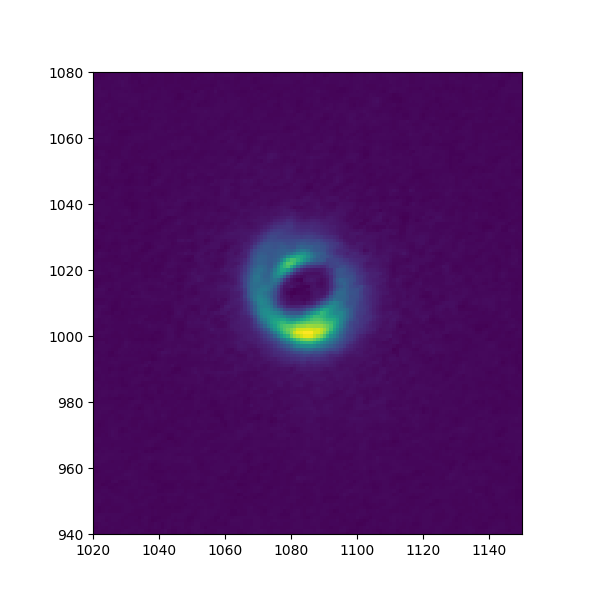

In [9]:
from skimage.transform import rotate, rescale

def deproject_disk(image, inc_deg, pa_astro_deg):
    """
    Deproject an inclined disk (PA: North-to-West).
    
    Parameters:
        image: 2D array (input image)
        inc_deg: inclination angle (0°=face-on, 90°=edge-on)
        pa_astro_deg: position angle (North-to-West) in degrees
    Returns:
        Deprojected image (face-on)
    """
    # Convert PA from North-to-West to standard mathematical convention
    pa_math_deg = 90 - pa_astro_deg
    
    # Step 1: Rotate to align major axis with x-axis
    rotated = rotate(image, -pa_math_deg, resize=True, mode='edge')
    
    # Step 2: Stretch y-axis by 1/cos(i)
    scale_y = 1 / np.cos(np.radians(inc_deg))
    deprojected = rescale(rotated, (scale_y, 1), mode='edge', anti_aliasing=True)

    # Step 3: Rotate back to original PA
    deprojected = rotate(deprojected, pa_math_deg, resize=True, mode='edge')
    
    return deprojected

little = wray_qphi.byteswap().newbyteorder() # converting the image to little-endian type order
wray_qphi_d = deproject_disk(wray_qphi, 36.4, 28.0) # we put the position angle and the inclination we found with ALMA data

# Let us see the deprojeccted disk image:
plt.figure(figsize=(6, 6))
plt.imshow(wray_qphi_d, origin='lower')
plt.xlim(1020, 1150)
plt.ylim(940, 1080)
plt.show()

We can see the slit in a plot:

In [10]:
from matplotlib.patches import Rectangle

x_center_d = 1084
y_center_d = 1014

def make_bordered_rectangle(x_base, y_base, width, height, thickness=0.5, label='', color='w', alpha=1.):
    """
    Draws a rectangle with only a border (transparent inside), positioned at the midpoint of its base.
    
    Parameters:
    - x_base, y_base: Coordinates of the midpoint of the base.
    - width, height: Dimensions of the rectangle.
    - thickness: Thickness of the border.
    - label: Label for legend (optional).
    - color: Border color (default: white).
    - alpha: Transparency (default: 1).
    """
    # Calculate bottom-left corner coordinates (since Rectangle uses this)
    bottom_left_x = x_base - width / 2
    bottom_left_y = y_base  # Base starts at y_base, extends upwards

    # Create the rectangle patch (only border, no fill)
    rect = Rectangle(
        (bottom_left_x, bottom_left_y),
        width, height,
        linewidth=thickness,
        edgecolor=color,
        facecolor='none',  # Transparent inside
        alpha=alpha,
        label=label
    )

    # Add to the current axis
    plt.gca().add_patch(rect)

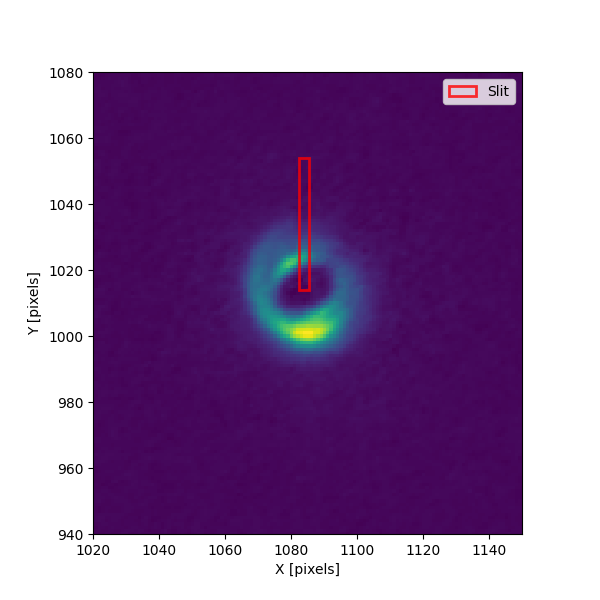

In [21]:
plt.figure(figsize=(6,6))
plt.imshow(wray_qphi_d, origin='lower')
make_bordered_rectangle(
    x_base=x_center_d, y_base=y_center_d, 
    width=3, height=40, 
    thickness=2.0,  # Thicker border
    color='red', 
    alpha=0.8,
    label='Slit'
)
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.legend(loc='best')
plt.xlim(1020, 1150)
plt.ylim(940, 1080)
plt.show()

Now we calculate the flux inside the slit for each angle (we make a rotation from 0 to 360 degrees with steps of 1 degree):

In [12]:
from matplotlib.patches import Polygon

def rotated_rectangle(x_base, y_base, width, height, angle_deg=0):
    """
    Generate vertices of a rotated rectangle centered at the midpoint of its base.
    
    Parameters:
    - x_base, y_base: Midpoint of the base before rotation.
    - width, height: Dimensions of the rectangle.
    - angle_deg: Rotation angle in degrees (counter-clockwise).
    
    Returns:
    - vertices: 4x2 array of rotated rectangle vertices.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Unrotated vertices (anchored at midpoint of base)
    half_width = width / 2
    vertices = np.array([
        [-half_width, 0],      # Bottom-left
        [half_width, 0],       # Bottom-right
        [half_width, height],  # Top-right
        [-half_width, height]  # Top-left
    ])
    
    # Rotation matrix
    rot_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    # Rotate and translate vertices
    rotated_vertices = np.dot(vertices, rot_matrix.T) + np.array([x_base, y_base])
    
    return rotated_vertices

def calculate_flux_in_rotated_rectangle(image, vertices):
    """
    Calculate flux inside a rotated rectangle defined by its vertices.
    
    Parameters:
    - image: 2D numpy array (image data).
    - vertices: 4x2 array of rectangle vertices.
    
    Returns:
    - Total flux inside the polygon.
    - Mask of the polygon (for visualization).
    """
    from matplotlib.path import Path
    
    # Create a meshgrid of pixel coordinates
    y_pixels, x_pixels = np.indices(image.shape)
    pixel_coords = np.column_stack((x_pixels.ravel(), y_pixels.ravel()))
    
    # Create a Path for the rotated rectangle
    rect_path = Path(vertices)
    
    # Check which pixels are inside the path
    mask = rect_path.contains_points(pixel_coords).reshape(image.shape)
    
    # Calculate total flux
    flux = np.sum(image[mask])
    
    return flux, mask

In [13]:
angle = np.zeros(360)
flux = np.zeros(360)
flux_mask = np.zeros(360)

for i in range (0, 360):
    rect = rotated_rectangle(x_center_d, y_center_d, 3, 40, angle_deg=i)
    angle[i] = i
    #f, mask = calculate_flux_in_rotated_rectangle(wray_masked, rect)
    #flux_mask[i] = f
    
    f, mask = calculate_flux_in_rotated_rectangle(wray_qphi_d, rect)
    flux[i] = f

#max_flux_mask = np.amax(flux_mask)
#norm_flux_mask = flux_mask/max_flux_mask

max_flux = np.amax(flux)
norm_flux = flux/max_flux

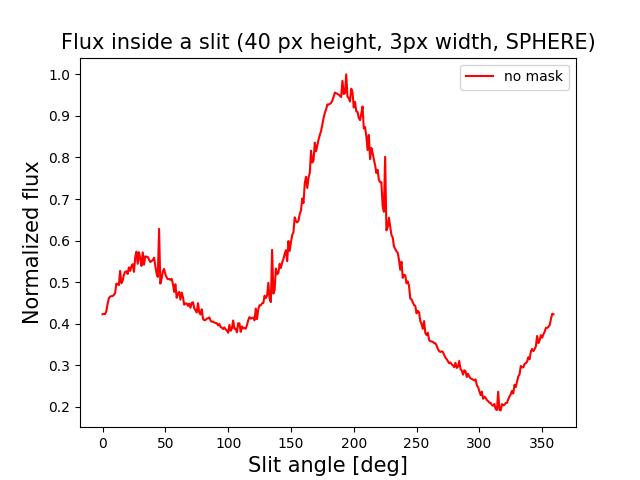

In [14]:
plt.figure()
plt.title('Flux inside a slit (40 px height, 3px width, SPHERE)', fontsize=15)
plt.plot(angle, norm_flux, 'r', label='no mask')
#plt.plot(angle, norm_flux_mask, 'b', label='mask')
plt.ylabel('Normalized flux', fontsize=15)
plt.xlabel('Slit angle [deg]', fontsize=15)
plt.legend()
plt.show()

In [15]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def gaussian(x, amplitude, mean, stddev):
    """Gaussian function for fitting."""
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def mask_peaks(signal, height_threshold, distance=10):
    """Finds peaks and returns a mask (True where no peaks are)."""
    peaks, _ = find_peaks(signal, height=height_threshold, distance=distance)
    mask = np.ones_like(signal, dtype=bool)
    mask[peaks] = False  # Exclude peaks from fit
    return mask

def fit_gaussian_excluding_peaks(x, y, height_threshold):
    """Fits a Gaussian while excluding peaks."""
    mask = mask_peaks(y, height_threshold)
    x_fit = x[mask]
    y_fit = y[mask]
    
    # Initial guess for Gaussian parameters
    mean_guess = np.mean(x_fit)
    std_guess = np.std(x_fit)
    amplitude_guess = np.max(y_fit)
    
    # Fit Gaussian
    popt, pcov = curve_fit(gaussian, x_fit, y_fit, 
                          p0=[amplitude_guess, mean_guess, std_guess])
    
    return popt, pcov  # Optimal parameters and covariance

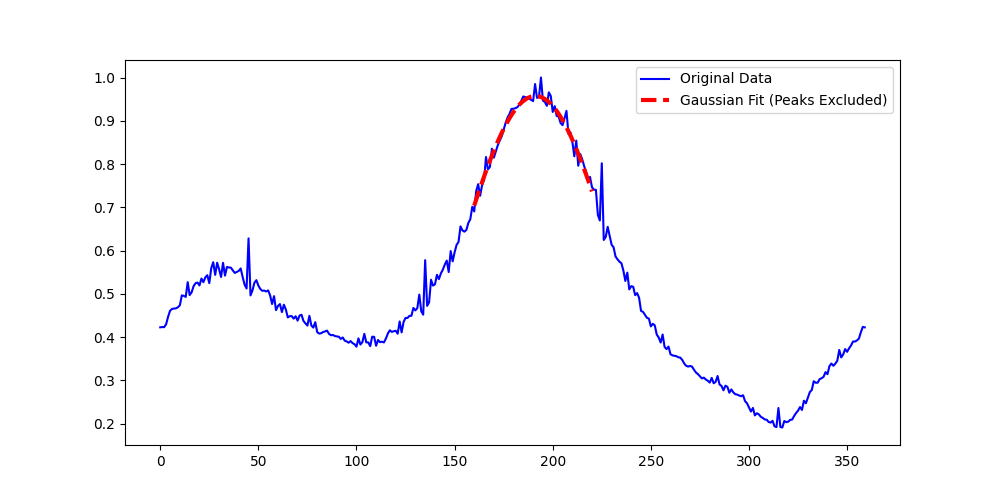

In [16]:
# Fit Gaussian while excluding peaks
height_threshold = 0.03  # Adjust based on your data

# Selecting only the luminosity peak that interests us:
mask = (angle >= 160) & (angle <= 220)
angle_masked = angle[mask]
norm_flux_masked = norm_flux[mask]
popt, pcov = fit_gaussian_excluding_peaks(angle_masked, norm_flux_masked, height_threshold)

# Reconstruct the fitted Gaussian
norm_flux_fit = gaussian(angle_masked, *popt)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(angle, norm_flux, 'b-', label="Original Data")
plt.plot(angle_masked, norm_flux_fit, 'r--', linewidth=3, label="Gaussian Fit (Peaks Excluded)")
plt.legend()
plt.show()

In [17]:
perr = np.sqrt(np.diag(pcov))

print ('fitted parameters:', popt)
print ('errors on the fitted parameters:', perr)
print ('final peak angle value:', popt[1], f'\u00B1', perr[1])

fitted parameters: [  0.95725952 191.20033908  39.80219865]
errors on the fitted parameters: [0.00271932 0.19964579 0.49191224]
final peak angle value: 191.2003390826413 ± 0.19964578625317916


So, the final result for our peak is **191.2 $\pm$ 0.2** deg. Knowing that the ALMA peak is at **215.6 $\pm$ 1.2** deg, the angle difference $\Delta\phi$ is:

**$\Delta\phi = 24.4 \pm 1.2$** deg.

Therefore, knowing that the time interval between ALMA and SPHERE observations is of $\sim$ 4.7 years, we have that:

**$P \sim 69 \, yr$**

**$a \sim 17 \, AU$**.

Now we show an image that indicates the **scale in arcsecs** for the disk and the **coronagraph**:

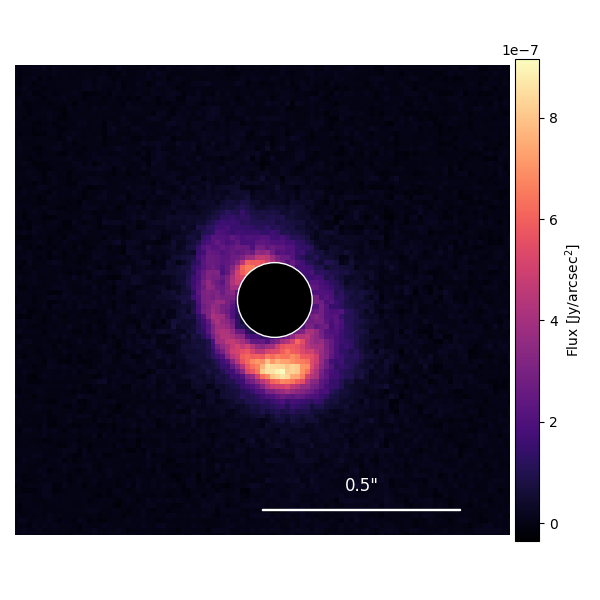

In [24]:
# Define circle parameters
scale = wray_hdu.header['SCALE'] # number of mas/px

x_center = wray_hdu.header['STAR_X']
y_center = wray_hdu.header['STAR_Y']
radius = 92.5/scale  # width of the coronograph in pixels: the coronograph has a radius of 92.5 mas

# Create a black circle with white edges
circle = patches.Circle(
    (x_center, y_center),  # Center position
    radius,                # Radius
    edgecolor='white',     # White circumference
    facecolor='black',     # Black fill
    linewidth=1,           # Line thickness
    alpha=1              # Optional: transparency (0-1)
)

# Add a white 100 mas scale bar (adjust position as needed)
scale_bar_length = 40  # mas
scale_bar_height = 0.3    # mas (thickness of the bar)
scale_bar_x = 510       # x-position (mas)
scale_bar_y = 470       # y-position (mas)

# Create a white rectangle
scale_bar = patches.Rectangle(
    (scale_bar_x, scale_bar_y),   # (x, y) position
    scale_bar_length,             # width (mas)
    scale_bar_height,             # height (mas)
    linewidth=1, edgecolor='white', facecolor='white'
)

plt.figure(figsize=(6, 6))
#plt.imshow(wray_qphi, norm=LogNorm(10**-8, vmax=wray_qphi.max()), origin='lower', cmap='magma')
plt.imshow(wray_qphi, origin='lower', cmap='magma')
plt.colorbar(fraction=0.046, pad=0.01, label=r"Flux [Jy/arcsec$^2$]")
plt.gca().add_patch(scale_bar)

# Optional: Add text label (e.g., "100 mas")
plt.text(
    scale_bar_x + scale_bar_length / 2,  # x-center of the bar
    scale_bar_y + 3,                   # y-position above the bar
"0.5\"", 
    color='white', 
    ha='center', 
    va='bottom',
    size=12
)

# Add the circle to the plot
plt.gca().add_patch(circle)

plt.axis('off')
plt.xlim(460, 560)
plt.ylim(465, 560)
plt.tight_layout()
plt.show()

In [25]:
from scipy.ndimage import map_coordinates

def create_polar_image(image, radius, output_shape=(200, 360)):
    h, w = image.shape
    center_y, center_x = h // 2, w // 2
    
    # Create output grid
    r = np.linspace(0, radius, output_shape[0])
    phi = np.linspace(0, 2 * np.pi, output_shape[1], endpoint=False)
    
    # Convert polar to Cartesian coordinates
    r_grid, phi_grid = np.meshgrid(r, phi, indexing='ij')
    x = r_grid * np.cos(phi_grid) + center_x
    y = r_grid * np.sin(phi_grid) + center_y
    
    # Stack coordinates for interpolation
    coords = np.vstack((y.flatten(), x.flatten()))
    
    # Here we map our image in the coordinate system 'coords' 
    polar_image = map_coordinates(image, coords, order=1, mode='constant')
    polar_image = polar_image.reshape(output_shape)
    
    return polar_image

wray_qphi_polar = create_polar_image(wray_qphi_d, 50, output_shape=(200, 360))

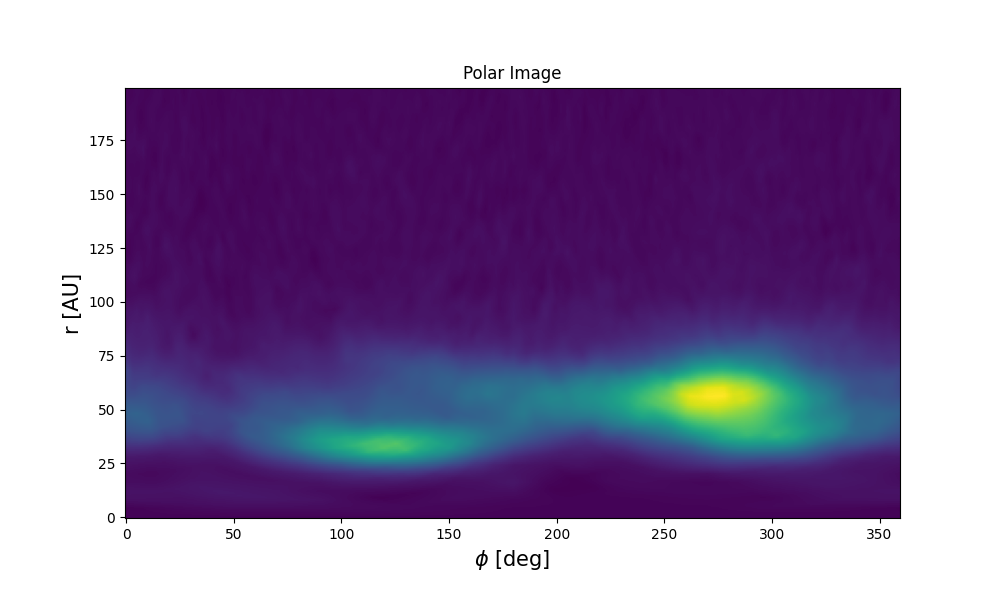

In [20]:
plt.figure(figsize=(10, 6))
plt.imshow(wray_qphi_polar, origin='lower')
plt.xlabel('$\phi$ [deg]', fontsize=15)
plt.ylabel('r [AU]', fontsize=15)
plt.title('Polar Image')
plt.show()